# PUBG Finish Placement Prediction

Player Unknown's BattleGrounds (PUBG) is a Battle Royale-style video game. In the game 100 players are dropped onto an island empty-handed and must explore, scavenge, and eliminate other players until only one is left standing, all while the play/safe zone continues to shrink.

The data covers over 65000 games worth of anonymized player data. The task is to predict final placement of players.

<center><img src="PUBG Inlay.jpg" width="500"/></center>

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
    
train = pd.read_csv('train_V2.csv')
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(train)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.8,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.0,5,0,0.6400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.40,1,1,2,11,0,2,1,98.50,1373,squad-fpp,26,25,1418,2,0.0000,0,0.00,0,0,2748.0,8,0,0.8000
4446965,0d8e7ed728b6fd,8c74f72fedf5ff,62a16aabcc095c,0,2,268.00,0,0,1,18,0,2,1,78.25,1766,solo-fpp,98,94,1590,0,1369.0000,0,0.00,0,0,1244.0,5,0,0.5464


## The Data

- Id: unique player identifier.
- groupId: unique group identifier (duos, squad)
- matchId: unique match identifier.
- DBNOs: (downed but not out) number of enemy players knocked.
- killPlace: ranking based on the number of enemy players killed.
- killPoints: points awarded to a team based on the number on the accumulated kills by the team. 
- matchType: string that identifies the game mode of the match. The standard modes are solo, duo, squad.
- numGroups: number of groups per match.
- maxPlace: worst placement got in the match.
- winPlacePerc: target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. 

In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

In [3]:
#Missing values
train.isna().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

In this case there was only one player in a match therefore he is deleted from the dataset

In [4]:
train.dropna(inplace = True )
train.isna().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       0
dtype: int64

## Feature Engineering

### Players Joined per Match

This is a valuable feature for the model. It is used to normalize other features and get stronger predictions on individual players.

C:\Users\jean-\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


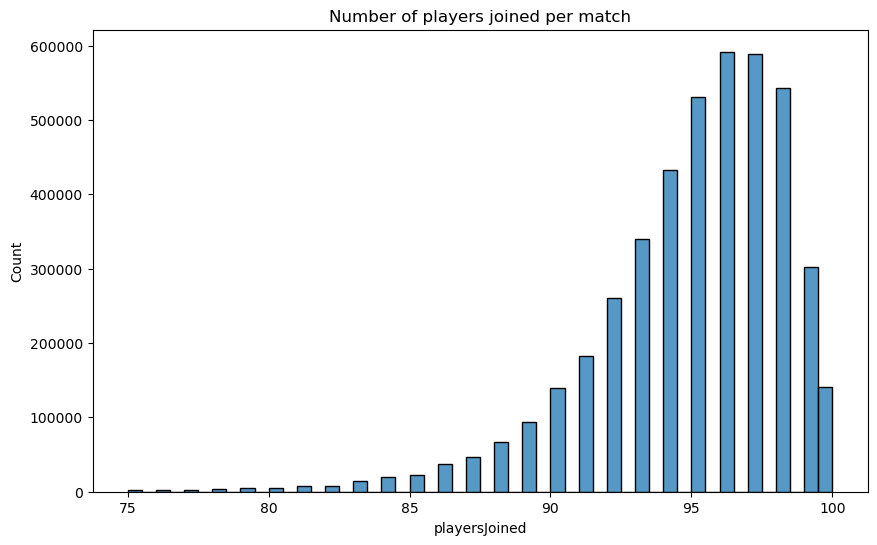

In [5]:
train['playersJoined'] = train.groupby('matchId')['matchId'].transform('count')
plt.figure(figsize=(10,6))
sns.histplot(train[train['playersJoined']>=75]['playersJoined'], binwidth=0.5)
plt.title('Number of players joined per match')
plt.show()

### Normalized Features

With the new feature 'playersJoined' other features can be normalized based on the number of players. Features that can be normalized are:

- kills

- damageDealt
  
- maxPlace
  
- matchDuration

In [6]:
#new normalized features
normalising_factor = (100 - train['playersJoined'])/100+1
train['killsNorm'] = train['kills'] * normalising_factor
train['damageDealtNorm'] = train['damageDealt'] * normalising_factor
train['maxPlaceNorm'] = train['maxPlace'] * normalising_factor
train['matchDurationNorm'] = train['matchDuration'] * normalising_factor

#compare standard features and normalized features
to_show = ['Id', 'kills','killsNorm','damageDealt', 'damageDealtNorm', 'maxPlace', 'maxPlaceNorm', 'matchDuration', 'matchDurationNorm', 'playersJoined']
train[to_show][0:11]

,Id,kills,killsNorm,damageDealt,damageDealtNorm,maxPlace,maxPlaceNorm,matchDuration,matchDurationNorm,playersJoined
0,7f96b2f878858a,0,0.00,0.000,0.00000,28,29.12,1306,1358.24,96
1,eef90569b9d03c,0,0.00,91.470,99.70230,26,28.34,1777,1936.93,91
2,1eaf90ac73de72,0,0.00,68.000,69.36000,50,51.00,1318,1344.36,98
3,4616d365dd2853,0,0.00,32.900,35.86100,31,33.79,1436,1565.24,91
4,315c96c26c9aac,1,1.03,100.000,103.00000,97,99.91,1424,1466.72,97
5,ff79c12f326506,1,1.05,100.000,105.00000,28,29.40,1395,1464.75,95
6,95959be0e21ca3,0,0.00,0.000,0.00000,28,28.84,1316,1355.48,97
7,311b84c6ff4390,0,0.00,8.538,8.87952,96,99.84,1967,2045.68,96
8,1a68204ccf9891,0,0.00,51.600,53.14800,28,28.84,1375,1416.25,97
9,e5bb5a43587253,0,0.00,37.270,38.38810,29,29.87,1930,1987.90,97


### Heals and Boosts

A new feature 'healsnboosts' is created by adding the number of heals and boosts during the match.

In [7]:
train['healsnboosts'] = train['heals'] + train['boosts']
train[['heals', 'boosts', 'healsnboosts']].tail()

,heals,boosts,healsnboosts
4446961,0,0,0
4446962,0,1,1
4446963,0,0,0
4446964,2,4,6
4446965,1,2,3


### Killing without moving

Lets try to identify cheaters/bots that have managed to get kills without moving not even 1 meter. First a new feature 'totaldistance' is created, this covers all the distance travelled by a player and then set a boolean value to True if someone got kills without moving a single centimeter.

In [8]:
# new parameter totaldistance, sums every distance travelled by the player
train['totaldistance']=train['walkDistance'] + train['rideDistance'] + train['swimDistance']
# new parameter killwithoutmoving to check if 
# a player has not moved but still managed to get kills
train['killwithoutmoving']=((train['kills']>0) & (train['totaldistance']==0))

### Headshot-rate

This is another feature to capture cheaters that have "perfect aim". 

In [9]:
#create a new parameter headshot_rate 
#in order to analyze players with perfect headshot-rate
train[(train['kills']==0)].shape
train['headshot_rate'] = train['headshotKills']/train['kills']
#division to 0 exception
train['headshot_rate'] =  train['headshot_rate'].fillna(0)

## Outlier Detection

### Kills without movement

This dataset has more tha 4 million entries, it is bound to have wierd values. These players can be cheaters, bots, crazy or just anomalies. Removing these players will improve the results. 

A player that hasn't moved troughout the game is already suspicious. But someone that hasn't moved and still managed to get kills, needs to be removed.

In [10]:
display(train[train['killwithoutmoving'] == True].shape)
train[train['killwithoutmoving'] == True].head(6)

(1535, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsnboosts,totaldistance,killwithoutmoving,headshot_rate
1824,b538d514ef2476,0eb2ce2f43f9d6,35e7d750e442e2,0,0,593.0,0,0,3,18,...,0.8571,58,8.52,842.060,21.30,842.06,3,0.0,True,0.000000
6673,6d3a61da07b7cb,2d8119b1544f87,904cecf36217df,2,0,346.6,0,0,6,33,...,0.6000,42,4.74,547.628,17.38,2834.52,6,0.0,True,0.000000
11892,550398a8f33db7,c3fd0e2abab0af,db6f6d1f0d4904,2,0,1750.0,0,4,5,3,...,0.8947,21,35.80,3132.500,35.80,1607.42,5,0.0,True,0.200000
14631,58d690ee461e9d,ea5b6630b33d67,dbf34301df5e53,0,0,157.8,0,0,0,69,...,0.0000,73,1.27,200.406,24.13,1014.73,0,0.0,True,0.000000
15591,49b61fc963d632,0f5c5f19d9cc21,904cecf36217df,0,0,100.0,0,1,0,37,...,0.3000,42,1.58,158.000,17.38,2834.52,0,0.0,True,1.000000
20881,40871bf43ddac7,2cea046b7d1dce,0600f86f11c6e4,0,0,506.1,4,1,3,7,...,0.8000,44,9.36,789.516,9.36,909.48,3,0.0,True,0.166667


In [11]:
# drop outliers
train.drop(train[train['killwithoutmoving'] == True].index , inplace = True)

### Roadkills

In [12]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(train[train['roadKills'] > 10])

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsnboosts,totaldistance,killwithoutmoving,headshot_rate
2733926,c3e444f7d1289f,489dd6d1f2b3bb,4797482205aaa4,0,0,1246.0,0,0,0,1,1403,14,13,7.181,1456,solo,92,80,-1,0,0.005,14,5.297,0,0,1277.0,0,1371,0.4286,92,15.12,1345.68,99.36,1572.48,0,1282.302,False,0.000000
2767999,34193085975338,bd7d50fa305700,a22354d036b3d6,0,0,1102.0,0,0,0,1,1497,11,11,0.000,1946,solo,88,77,-1,0,4118.000,11,0.000,0,0,816.6,5,1533,0.4713,88,12.32,1234.24,98.56,2179.52,0,4934.600,False,0.000000
2890740,a3438934e3e535,1081c315a80d14,fe744430ac0070,0,8,2074.0,0,1,11,1,1114,20,18,64.290,1970,solo,38,20,-1,0,2726.000,18,0.000,0,0,3150.0,4,1568,1.0000,38,32.40,3359.88,61.56,3191.40,19,5876.000,False,0.050000
3524413,9d9d044f81de72,8be97e1ba792e3,859e2c2db5b125,0,3,1866.0,0,5,7,1,1520,18,11,341.400,1925,solo,84,70,-1,0,6812.000,11,0.000,0,0,1041.0,10,1606,0.9398,84,20.88,2164.56,97.44,2233.00,10,7853.000,False,0.277778


This particular player 'c3e444f7d1289f' has 14 roadkills with not even 10 meters driven. 

In [13]:
# drop roadKill 'cheaters'
train.drop(train[train['roadKills'] > 10].index, inplace=True)

<center><img src="giphy1.gif" width="500"/></center>

### Anomalies in aim

### Perfect Headshot-rate

With the feature headshot_rate lets display how good is the accuracy of the players.

C:\Users\jean-\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


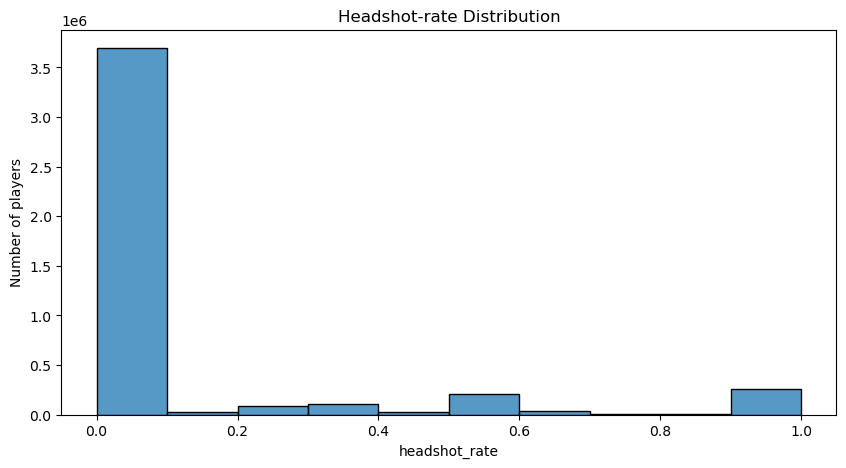

In [14]:
# plot the distribution of headshot_rate
plt.figure(figsize=(10,5))
sns.histplot(train['headshot_rate'], bins=10).set_title("Headshot-rate Distribution")
plt.ylabel("Number of players")
plt.show()

In [15]:
#get rid of players with a perfect headshot rate 
#who have more than 9 kills
train[(train['headshot_rate'] ==1) & (train['kills']>9)].shape

(24, 38)

In [16]:
# Remove outliers
train.drop(train[(train['headshot_rate'] ==1) & (train['kills']>9)].index, inplace=True)

<center><img src="giphy2.gif" width="700"/></center>

### Longest Kill

Most of the kills are achieved in a distance of 100 meters or closer. Let's display the players who have got a kill beyond 1 km.

C:\Users\jean-\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


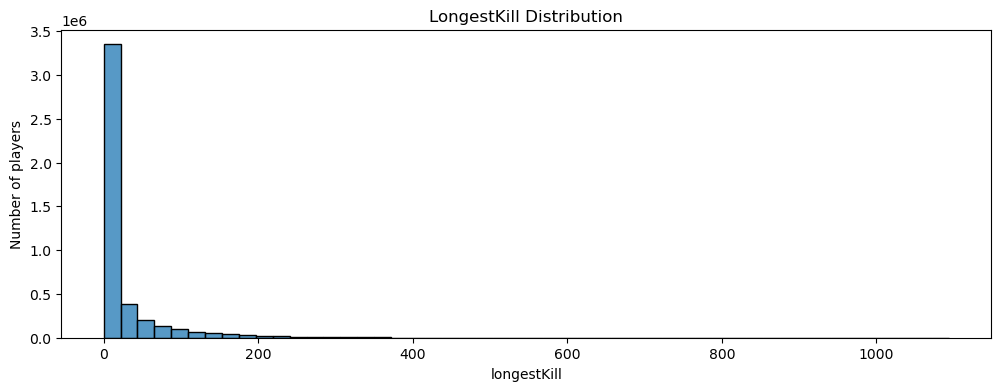

In [17]:
# plot the distribution of longestKill
plt.figure(figsize=(12,4))
sns.histplot(train['longestKill'], bins=50).set_title("LongestKill Distribution")
plt.ylabel("Number of players")
plt.show()

In [18]:
# players who made kills with a distance of more than 1 km
display(train[train['longestKill'] >= 1000].shape)

(20, 38)

In [19]:
train.drop(train[train['longestKill']>=1000].index, inplace = True)

### Weapons acquired

C:\Users\jean-\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


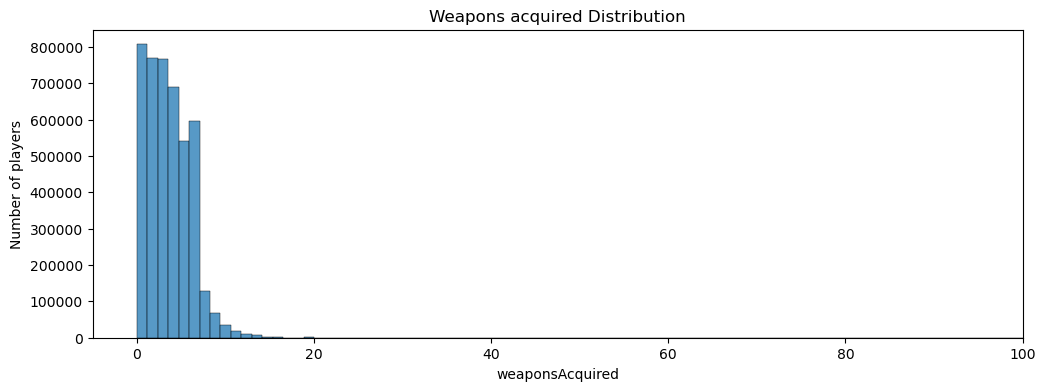

In [20]:
# distribution of weaponsAcquired
plt.figure(figsize=(12,4))
sns.histplot(train['weaponsAcquired'], bins=200).set_title("Weapons acquired Distribution")
plt.ylabel("Number of players")
plt.xlim(-5, 100)
plt.show()

In [21]:
# players who acquired more than 80 weapons
display(train[train['weaponsAcquired'] >= 80].shape)

(21, 38)

In [22]:
# remove outliers
train.drop(train[train['weaponsAcquired'] >= 80].index, inplace=True)

### Heals used

Most players use 10 healing items or less.

C:\Users\jean-\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


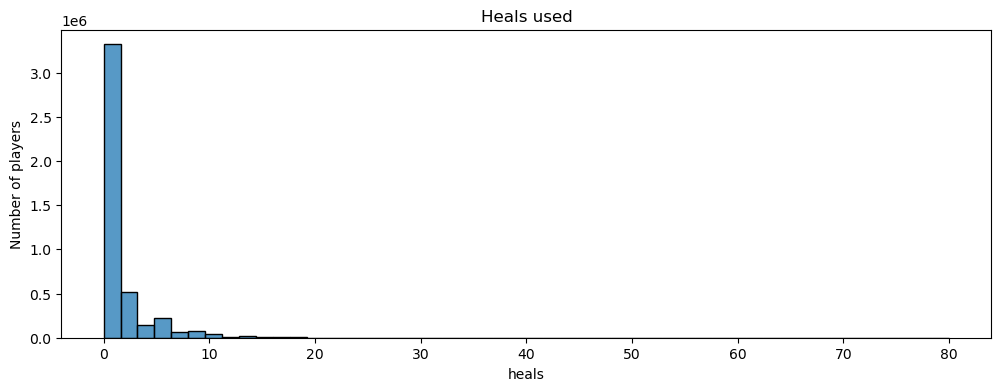

In [23]:
# distribution of heals
plt.figure(figsize=(12,4))
sns.histplot(train['heals'], bins=50).set_title("Heals used")
plt.ylabel("Number of players")
plt.show()

In [24]:
# 40 or more healing items used
display(train[train['heals'] >= 40].shape)

(135, 38)

In [25]:
# Remove outliers
train.drop(train[train['heals'] >= 40].index, inplace=True)

### Outlier conclusions

1809 players have been removed from the dataset. 

In [26]:
# Remaining players in the training set
train.shape

(4445226, 38)

### Players Placement

In [27]:
winners=train[(train['winPlacePerc'] ==1)].shape
loosers=train[(train['winPlacePerc'] != 1)].shape
c25=train[(train['winPlacePerc'] <=0.25)].shape
c50=train[(train['winPlacePerc'] >0.25) & (train['winPlacePerc']<0.50)].shape
c75=train[(train['winPlacePerc'] >0.50) & (train['winPlacePerc']<0.75)].shape
c100=train[(train['winPlacePerc'] >=0.75)].shape
c=c25[0]+c50[0]+c75[0]+c100[0]

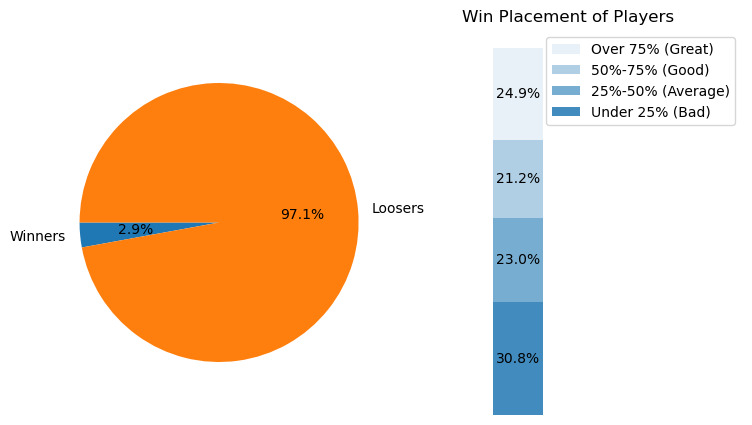

In [28]:
# make figure and assign axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
fig.subplots_adjust(wspace=0)
# pie chart parameters
overall = [winners[0],loosers[0]]
labels = ["Winners","Loosers"]

# rotate so that first wedge is split by the x-axis
angle = -180 * overall[1]
wedges, *_ = ax1.pie(overall, autopct='%1.1f%%', startangle=angle,labels=labels)

# bar chart parameters
ratios = np.array([c25[0], c50[0], c75[0], c100[0]])
ratios=ratios/c
ratios =np.round(ratios,3)
plac_labels = ['Under 25% (Bad)', '25%-50% (Average)', '50%-75% (Good)', 'Over 75% (Great)']
bottom = 1
width = .2

# Adding from the top matches the legend.
for j, (height, label) in enumerate(reversed([*zip(ratios,plac_labels)])):
    bottom -= height
    bc = ax2.bar(0, height, width, bottom=bottom, color='C0', label=label,
                 alpha=0.1 + 0.25 * j)
    ax2.bar_label(bc, labels=[f"{height:.1%}"], label_type='center')

ax2.set_title('Win Placement of Players')
ax2.legend()
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 4.5 * width)
plt.show()

## Categorical Values

In [29]:
#what are the categorical values of the dataset?
cat_cols = train.select_dtypes(include = 'O').columns
cat_cols

Index(['Id', 'groupId', 'matchId', 'matchType'], dtype='object')

In [30]:
#handeling categorical data
from sklearn.preprocessing import LabelEncoder
match = LabelEncoder()
train['matchType'].value_counts()

matchType
squad-fpp           1756107
duo-fpp              996657
squad                626500
solo-fpp             536562
duo                  313569
solo                 181902
normal-squad-fpp      16217
crashfpp               6287
normal-duo-fpp         5408
flaretpp               2505
normal-solo-fpp        1497
flarefpp                718
normal-squad            454
crashtpp                371
normal-solo             280
normal-duo              192
Name: count, dtype: int64

In [31]:
train['matchType']= match.fit_transform(train[['matchType']])
train['matchType'].value_counts()

C:\Users\jean-\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


matchType
15    1756107
3      996657
14     626500
13     536562
2      313569
12     181902
11      16217
0        6287
7        5408
5        2505
9        1497
4         718
10        454
1         371
8         280
6         192
Name: count, dtype: int64

In [32]:
train = train.drop(columns = ['Id', 'groupId', 'matchId', 'assists', 'boosts', 'walkDistance', 'swimDistance', 
                          'rideDistance', 'heals', 'revives', 'kills', 'damageDealt', 'maxPlace', 'matchDuration'])

## Machine Learning

In [33]:
# Take sample for debugging and exploration
sample = 100000
df_sample = train.sample(sample)

In [34]:
y = df_sample['winPlacePerc']
X  = df_sample.drop(columns='winPlacePerc')

In [35]:
from sklearn.model_selection import train_test_split
x_train, x_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3)

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from math import sqrt
lr = LinearRegression()
lr.fit(x_train , Y_train)
p_lr = lr.predict(x_test)
MEA_lr = metrics.mean_absolute_error(Y_test,p_lr)
MSE_lr = metrics.mean_squared_error(Y_test,p_lr)
RMSE_lr = sqrt(MSE_lr)
r2_lr = metrics.r2_score(Y_test,p_lr)
r2_lr = format(r2_lr, ".0%")

In [37]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(random_state=42)
dt.fit(x_train , Y_train)
p_dt = dt.predict(x_test)
MEA_dt = metrics.mean_absolute_error(Y_test,p_dt)
MSE_dt = metrics.mean_squared_error(Y_test,p_dt)
RMSE_dt = sqrt(MSE_dt) 
r2_dt = metrics.r2_score(Y_test,p_dt)
r2_dt = format(r2_dt, ".0%")

In [38]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(x_train, Y_train)
p_knn = knn.predict(x_test)
MEA_knn = metrics.mean_absolute_error(Y_test,p_knn)
MSE_knn = metrics.mean_squared_error(Y_test,p_knn)
RMSE_knn = sqrt(MSE_knn)
r2_knn = metrics.r2_score(Y_test,p_knn)
r2_knn = format(r2_knn, ".0%")

In [39]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=80, min_samples_leaf=3, max_features='sqrt', n_jobs=-1)
rf.fit(x_train , Y_train)
rf.score(x_test , Y_test)
p_rf = rf.predict(x_test)
MEA_rf = metrics.mean_absolute_error(Y_test,p_rf)
MSE_rf = metrics.mean_squared_error(Y_test,p_rf)
RMSE_rf = sqrt(MSE_rf)
r2_rf = metrics.r2_score(Y_test,p_rf)
r2_rf = format(r2_rf, ".0%")

## Results

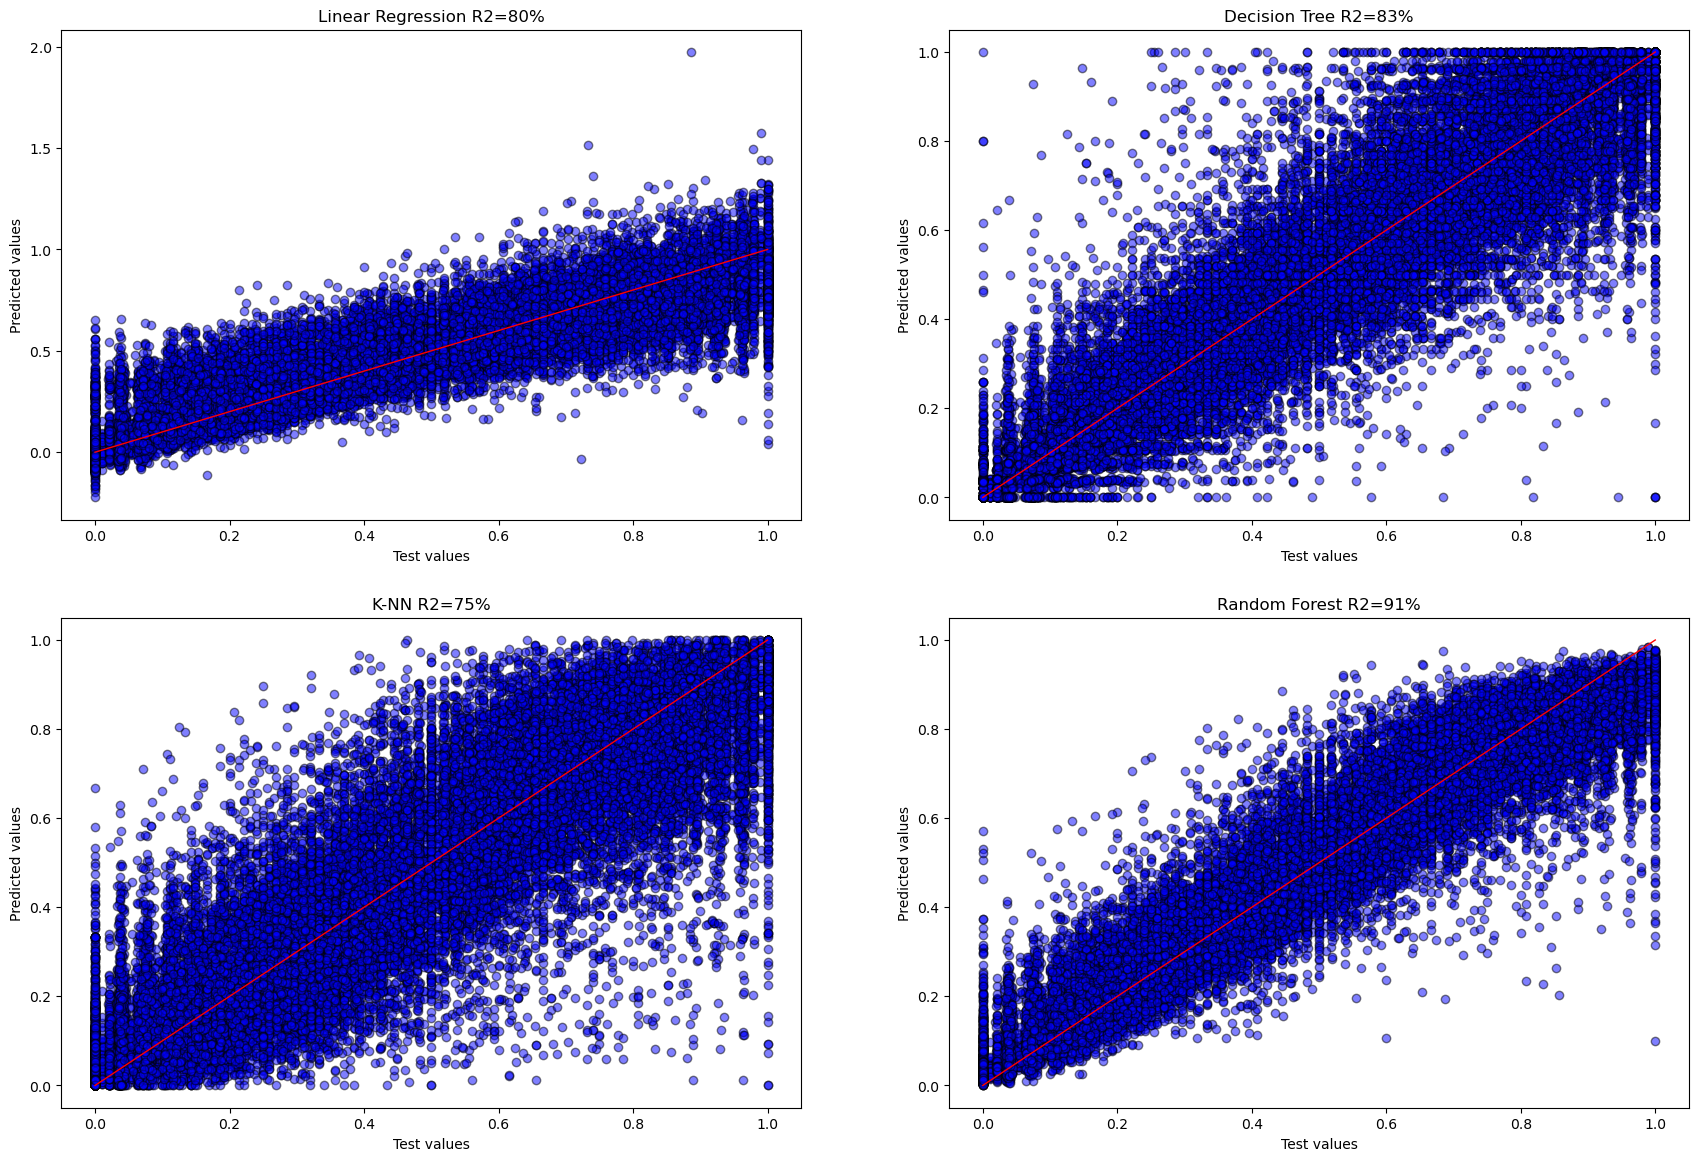

In [40]:
Y_max = Y_test.max()
Y_min = Y_test.min()
X_ref = Y_ref = np.linspace(Y_min, Y_max, 100)

figure, axis = plt.subplots(2, 2, figsize=(21,14)) 
# Linear Regression 
axis[0, 0].scatter(Y_test, p_lr, c='b', edgecolors=(0, 0, 0), alpha=0.5)
axis[0, 0].set_title("Linear Regression R2={}".format(r2_lr, ".0%"))
axis[0, 0].plot(X_ref, Y_ref, color='red', linewidth=1)
axis[0, 0].set_xlabel('Test values')
axis[0, 0].set_ylabel('Predicted values')
# Decision Tree 
axis[0, 1].scatter(Y_test, p_dt, c='b', edgecolors=(0, 0, 0), alpha=0.5)
axis[0, 1].set_title("Decision Tree R2={}".format(r2_dt, ".0%"))
axis[0, 1].plot(X_ref, Y_ref, color='red', linewidth=1)
axis[0, 1].set_xlabel('Test values')
axis[0, 1].set_ylabel('Predicted values')
# K-NN
axis[1, 0].scatter(Y_test, p_knn, c='b', edgecolors=(0, 0, 0), alpha=0.5)
axis[1, 0].set_title("K-NN R2={}".format(r2_knn, ".0%"))
axis[1, 0].plot(X_ref, Y_ref, color='red', linewidth=1)
axis[1, 0].set_xlabel('Test values')
axis[1, 0].set_ylabel('Predicted values')
# Adaboost 
axis[1, 1].scatter(Y_test, p_rf, c='b', edgecolors=(0, 0, 0), alpha=0.5)
axis[1, 1].set_title("Random Forest R2={}".format(r2_rf, ".0%"))
axis[1, 1].plot(X_ref, Y_ref, color='red', linewidth=1)
axis[1, 1].set_xlabel('Test values')
axis[1, 1].set_ylabel('Predicted values')
# Combine all the operations and display
plt.show() 

In [41]:
Methods = ['Linear Regression', 'Decision Tree', '3-NN', 'Random Forest']
MEA_all = [MEA_lr,MEA_dt,MEA_knn,MEA_rf]
MSE_all = [MSE_lr,MSE_dt,MSE_knn,MSE_rf]
RMSE_all = [RMSE_lr,RMSE_dt,RMSE_knn,RMSE_rf]
R2_all = [r2_lr,r2_dt,r2_knn,r2_rf]

In [42]:
pred_y_df=pd.DataFrame({'Algorithm':Methods,'MAE':MEA_all,'MSE':MSE_all,'RMSE':RMSE_all,'R2':R2_all})
pred_y_df[0:4]

,Algorithm,MAE,MSE,RMSE,R2
0,Linear Regression,0.102497,0.019114,0.138252,80%
1,Decision Tree,0.086994,0.015727,0.125409,83%
2,3-NN,0.112469,0.023306,0.152662,75%
3,Random Forest,0.066885,0.008594,0.092702,91%


Text(0.5, 1.0, 'Global Feature Importance')

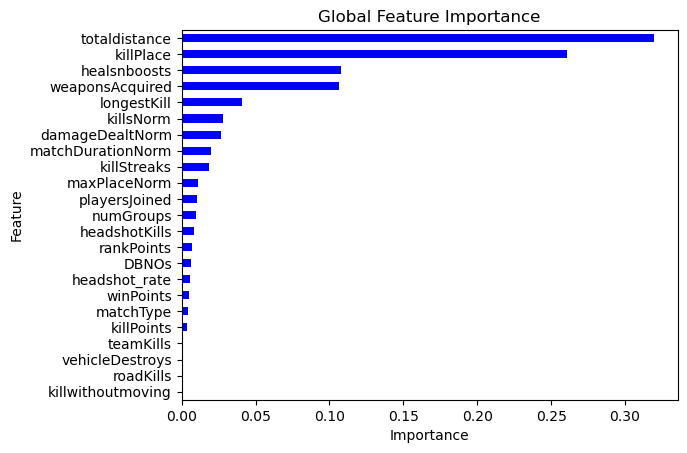

In [43]:
global_importances = pd.Series(rf.feature_importances_, index=x_train.columns)
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot.barh(color='blue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance")
